# Predict Air Pollution

#### Pedagogical objectives
- Prepare the data (for real)
- Further dig into Recurrent Neural Networks
- Stack multiple layers of RNNs

#### ML objective
- predict the **air pollution on the next day**
- given a sequence of weather features, such as the temperature, the pression, etc..
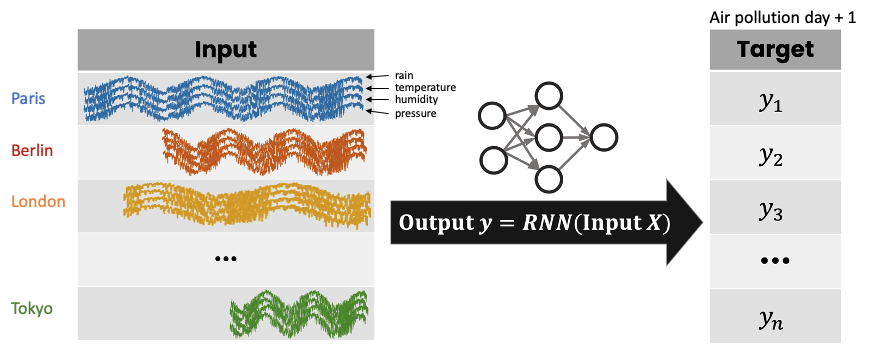

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

## 1. Preprocessing

### 1.1 Load and inspect data

In [2]:
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


☝️ The data here corresponds to hourly measurements of the air pollution (feature: `pm2.5`, which is the concentration of 2.5 millimeter particles) that you will try to predict. Among the other related features, you have:
- TEMP: Temperature
- DEWP: Dew Point
- PRES: Pressure
- Ir: Cumulated hours of rain
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow

❓ **Question** ❓ Plot the temporal progression of the different variables to get an intuition about the problem. How many years of data do we have? Are some feature visually correlated with the target?

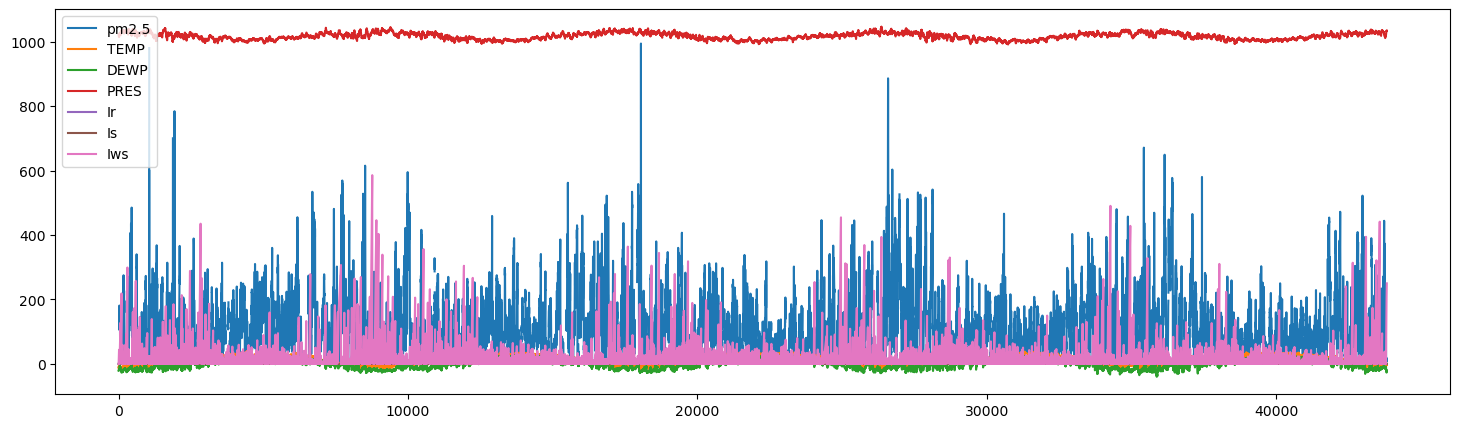

In [3]:
fig = plt.figure(1, figsize=(18, 5))
plt.plot(df)
plt.legend(df, loc = 'upper left')
plt.show()

In [4]:
years = round(43824/8760)
f"We have {years} years of data."

'We have 5 years of data.'

### 1.2 Create sequences (`X`,`y`) 

In the previous exercises, we had multiple independent data sequences. Here, you notice that there is only one. And this is quite often the case. So how to deal with such data? In fact, this long sequence can be separated in a lot of short sequences that we will consider as independent. 
![image.png](attachment:image.png)

This section aims to create a training set suitable for a RNN:
```python
X.shape = (n_sequences, length, n_features) # e.g. (100, 20, 7)
y.shape = (n_sequences, ) # e.g. (100,)
```

❓ **Question** ❓ Code the function `subsample_sequence` below such that it returns something like
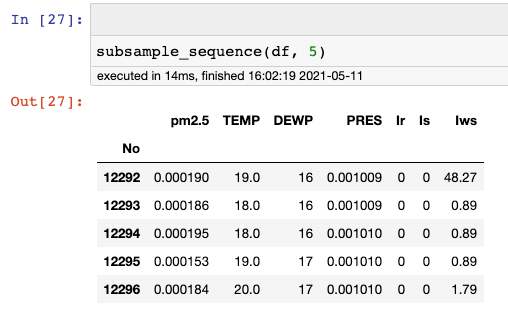

In [5]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    start_indice = np.random.choice(len(df)-length+1, replace=False)
    all_indices = [x for x in range(start_indice,start_indice+length)]
    df_sample = df.take(all_indices)
    return df_sample


In [6]:
# Test it 
assert subsample_sequence(df, 10).shape == (10, 7)
assert subsample_sequence(df, 40000).shape == (40000, 7)

❓ **Question** ❓ Write a function that given a full dataframe `df`:
- Subsamples this dataset into a shorter sequence of length `length`
- Stores the value of the pollution of the last day as your variable array `y`
- Stores all features of previous days as a variable `X`
- Returns (`X`, `y`)


In [7]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    df_sample = subsample_sequence(df, length)
    y_sample = df_sample.iloc[0+(length-1)][0]
    X_sample = df_sample.iloc[0:-1]
    
    return np.array(X_sample), np.array(y_sample)

In [8]:
# Test it
(X_sample, y_sample) = split_subsample_sequence(df, 10)
assert X_sample.shape == (9,7)
assert y_sample.shape == ()

🚨 There are missing values in the dataframe. Let's deal with it: 

- If the value to predict `y` is missing, the function should re-run.
- If there are missing values in the variables `X`, then it should be replaced by the mean values over the other selected hours. 
- If all the other hours are missing, then they should all be replaced by the mean value of the dataframe.

❓ **Question (HARD)** ❓ Try to update your function above taking this into account. Use the solution below if you don't find the answer.


<details>
    <summary>🆘  solution </summary>
    

```python
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)
```
</details>

In [9]:
#try to write the function by myself  
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    df_sample = subsample_sequence(df, length)
    y_sample = df_sample.iloc[0+(length-1)][0]
    X_sample = df_sample.iloc[0:-1]
    
    if y_sample == 'NaN' or y_sample == 'nan':
        split_subsample_sequence(df, lenght)
    
    X_sample = X_sample.fillna(X_sample.mean())
    
    
    return np.array(X_sample), np.array(y_sample)
    

In [10]:
# use of the given solution
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()

    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)

    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)

    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [11]:
(X_sample, y_sample) = split_subsample_sequence(df, 21)
X_sample.shape

(20, 7)

In [12]:
X_sample

array([[ 2.300e+01,  1.500e+01, -1.800e+01,  1.014e+03,  0.000e+00,
         0.000e+00,  1.790e+00],
       [ 2.700e+01,  1.400e+01, -1.700e+01,  1.014e+03,  0.000e+00,
         0.000e+00,  4.920e+00],
       [ 2.770e+02,  1.100e+01, -1.700e+01,  1.013e+03,  0.000e+00,
         0.000e+00,  6.710e+00],
       [ 2.730e+02,  1.100e+01, -7.000e+00,  1.014e+03,  0.000e+00,
         0.000e+00,  1.163e+01],
       [ 2.410e+02,  9.000e+00, -6.000e+00,  1.014e+03,  0.000e+00,
         0.000e+00,  1.476e+01],
       [ 2.590e+02,  7.000e+00, -5.000e+00,  1.014e+03,  0.000e+00,
         0.000e+00,  1.655e+01],
       [ 2.590e+02,  1.000e+00, -7.000e+00,  1.014e+03,  0.000e+00,
         0.000e+00,  1.834e+01],
       [ 2.650e+02,  4.000e+00, -4.000e+00,  1.014e+03,  0.000e+00,
         0.000e+00,  8.900e-01],
       [ 3.670e+02,  3.000e+00, -5.000e+00,  1.013e+03,  0.000e+00,
         0.000e+00,  1.780e+00],
       [ 3.920e+02,  4.000e+00, -1.000e+00,  1.011e+03,  0.000e+00,
         0.000e+00,  4.

❓ **Question** ❓ Write a last (!) function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [13]:
def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X = []
    y = []
    for sequence in range(n_sequences):
        
        (X_sample, y_sample) = split_subsample_sequence(df, length)
        X.append(X_sample)
        y.append(y_sample)
    
    X = np.array(X)
    y = np.array(y)
        
    return X, y

❓ **Question** ❓ Generate your dataset $(X, y)$ of `2000` sequences, each of `20` observations + the value of the pollution at the 21-st day to predict. That's about 40,000 observations, roughly equivalent to our dataset

In [14]:
X, y = get_X_y(df, 2000, 21)
X.shape

(2000, 20, 7)

In [15]:
# Check your code below
assert X.shape == (2000, 20, 7)
assert y.shape == (2000, )
assert np.isnan(X).sum() == 0

### 1.3 Train Test Split

🚨 **IMPORTANT REMARK: POTENTIAL DATA LEAKAGE** 🚨 If you split this dataset (X, y) into a training and a test set, it is much likely that some data in the train set are in the test set. Especially, you will predict data in test that are input data in train.

To avoid this situation, you should _first_ separate your initial dataframe `df` into a training dataframe and test dataframe as below

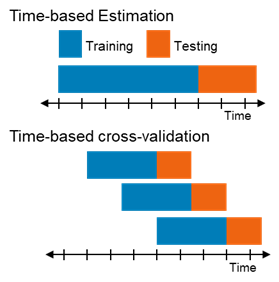


❓ **Question** ❓ Let's not cross-validate in this challenge to start with 🤯 
- Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training, and the last 20% in the test set.
- Then generate (`X_train`, `y_train`) from `df_train` and (`X_test`, `y_test`) from `df_test`
- Ensure that `X_train.shape == (2000, 20, 7)`

In [16]:
#test_size = int(20*len(df)/100)
#df_train = df[:-test_size]
#df_test = df[-test_size:]

In [17]:
#(X_train, y_train) = get_X_y(df_train, 2000, 21)
#(X_test, y_test) = get_X_y(df_train, 2000, 21)

In [18]:
def split_data(nb_sequences=2000, nb_days=21):
    test_size = int(20*len(df)/100)
    df_train = df[:-test_size]
    df_test = df[-test_size:]
    (X_train, y_train) = get_X_y(df_train, nb_sequences, nb_days)
    (X_test, y_test) = get_X_y(df_train, nb_sequences, nb_days)
    
    return X_train, y_train, X_test, y_test
    

In [19]:
X_train, y_train, X_test, y_test = split_data()

In [20]:
assert X_train.shape == (2000, 20, 7)

## 2. Predict pollution !

❓ **Question** ❓ First, what is your benchmark prediction to beat?  
Let's measure our performance in terms of *Mean Absolute Percentage Error (MAPE)* for this Time Serie challenge!

In [21]:
def MAPE(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape


### 2.1 Simple LSTM

❓ **Question** ❓ Now, let's try here with a simple single-layer `LSTM`

- Initialize a model the way you want and compile it within the `init_model` function.
- Then, **Fit** your model and evaluate it on the test data using the `mape` metric (useful in time series)

💡 Pro tips:
- Look at the scale of your feature: Scale them features if needed
- Look at the scale of your target: If smaller than usual, increase the learning rate vs. default values!
- Don't forget to plot your loss history to get visual feedback

In [22]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def init_model(X_train):
    
    model = Sequential()
    model.add(LSTM(10,input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae',optimizer='adam')
    return model
  

2023-03-23 10:15:12.667961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model = init_model(X_train)
model.summary()

2023-03-23 10:15:17.455837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                720       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [24]:
es = EarlyStopping(patience=5)
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,  
    verbose=1,
    batch_size=32, callbacks=[es])

Epoch 1/100
50/50 [==============================] - 2s 11ms/step - loss: 96.3300 - val_loss: 93.9110
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 95.1934 - val_loss: 93.2022
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 94.6227 - val_loss: 92.5462
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 94.1680 - val_loss: 92.2645
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 93.8969 - val_loss: 92.0002
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 93.6374 - val_loss: 91.7432
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 93.3844 - val_loss: 91.4922
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 93.1359 - val_loss: 91.2435
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 92.8892 - val_loss: 90.9980
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss: 92.6446 - val_lo

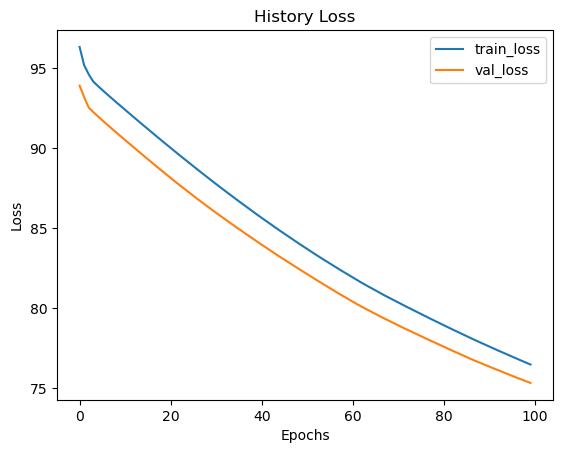

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('History Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
y_pred = model.predict(X_test)

evaluate = mean_absolute_percentage_error(y_test, y_pred)*100
evaluate

63/63 [==============================] - 0s 1ms/step


74.40257769316496

### 2.3 Stack RNN layers

❓ **Question** ❓ Now that you know how to write a recurrent architecture, let's see how to stack one.
If you want to stack multiple RNN, LSTM, GRU layers, it is very easy. Do it as if they were Dense (or any other) layers.

But don't forget: All RNN (**EXCEPT** the last one) should have the `return_sequences` set to True so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

In [85]:
from keras.metrics import MeanAbsolutePercentageError
def init_model(X_train):
    es = EarlyStopping(patience=1)
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae',optimizer='adam', metrics=[MeanAbsolutePercentageError()])
    return model

In [86]:
model = init_model(X_train)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20, 64)            18432     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    validation_split=0.2,  
    verbose=1,
    batch_size=64, callbacks=[es])

Epoch 1/500
25/25 [==============================] - 3s 39ms/step - loss: 96.9928 - mean_absolute_percentage_error: 96.7055 - val_loss: 94.5323 - val_mean_absolute_percentage_error: 92.6046
Epoch 2/500
25/25 [==============================] - 0s 15ms/step - loss: 94.3469 - mean_absolute_percentage_error: 89.6554 - val_loss: 91.6513 - val_mean_absolute_percentage_error: 84.9526
Epoch 3/500
25/25 [==============================] - 0s 15ms/step - loss: 91.2625 - mean_absolute_percentage_error: 81.8378 - val_loss: 88.5365 - val_mean_absolute_percentage_error: 78.0776
Epoch 4/500
25/25 [==============================] - 0s 16ms/step - loss: 88.1110 - mean_absolute_percentage_error: 75.3681 - val_loss: 85.4509 - val_mean_absolute_percentage_error: 73.7688
Epoch 5/500
25/25 [==============================] - 0s 16ms/step - loss: 84.9769 - mean_absolute_percentage_error: 71.6123 - val_loss: 82.4981 - val_mean_absolute_percentage_error: 72.7896
Epoch 6/500
25/25 [==============================]

Epoch 44/500
25/25 [==============================] - 1s 23ms/step - loss: 23.0981 - mean_absolute_percentage_error: 31.1158 - val_loss: 23.3166 - val_mean_absolute_percentage_error: 42.3003
Epoch 45/500
25/25 [==============================] - 0s 20ms/step - loss: 22.4820 - mean_absolute_percentage_error: 30.7377 - val_loss: 22.1397 - val_mean_absolute_percentage_error: 32.3284
Epoch 46/500
25/25 [==============================] - 1s 20ms/step - loss: 22.6060 - mean_absolute_percentage_error: 30.1900 - val_loss: 21.6455 - val_mean_absolute_percentage_error: 31.1872
Epoch 47/500
25/25 [==============================] - 0s 19ms/step - loss: 22.2912 - mean_absolute_percentage_error: 29.3845 - val_loss: 21.6038 - val_mean_absolute_percentage_error: 34.8266
Epoch 48/500
25/25 [==============================] - 0s 18ms/step - loss: 22.1526 - mean_absolute_percentage_error: 29.0764 - val_loss: 21.6995 - val_mean_absolute_percentage_error: 30.7571
Epoch 49/500
25/25 [=========================

Epoch 87/500
25/25 [==============================] - 0s 18ms/step - loss: 16.5500 - mean_absolute_percentage_error: 24.6985 - val_loss: 16.3034 - val_mean_absolute_percentage_error: 32.5590
Epoch 88/500
25/25 [==============================] - 0s 18ms/step - loss: 16.2028 - mean_absolute_percentage_error: 25.3419 - val_loss: 16.3113 - val_mean_absolute_percentage_error: 30.6633
Epoch 89/500
25/25 [==============================] - 0s 17ms/step - loss: 17.1297 - mean_absolute_percentage_error: 26.6340 - val_loss: 17.1894 - val_mean_absolute_percentage_error: 38.9906
Epoch 90/500
25/25 [==============================] - 0s 18ms/step - loss: 16.6028 - mean_absolute_percentage_error: 26.5186 - val_loss: 16.9603 - val_mean_absolute_percentage_error: 35.0395


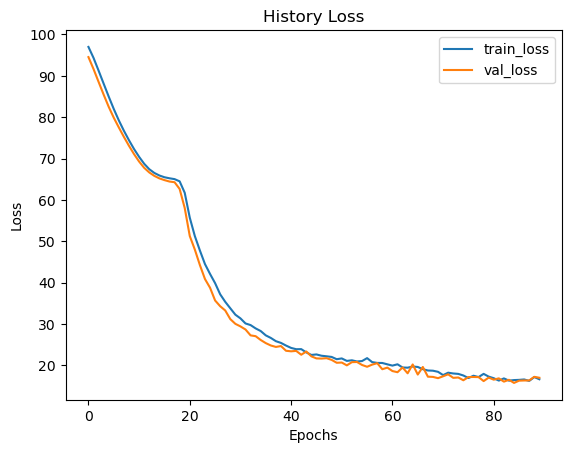

In [88]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('History Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred = model.predict(X_test)

evaluate = mean_absolute_percentage_error(y_test, y_pred)*100
evaluate

63/63 [==============================] - 0s 1ms/step


74.40257769316496

In [28]:
MAPE(y_test, y_pred)

74.40181637733852

## 3.  Check effect of data size on performance

❓ **Question** ❓ Now, let's see how the performance changes depending on

- the number of days in each sequence (20+1 days in the previous example).
- the number of sequences (2000 sequences in our previous example)

For different values of temporal sequence lengths, re-split your data, run your model and evaluate its performance. We advise to wrap this analysis into the function below

In [29]:
def train_model(nb_sequences=1000, nb_days=21):
    '''returns the MAPE on the train set'''
    # split data
    X_train, y_train, X_test, y_test = split_data(nb_sequences, nb_days)
    # init model
    model = init_model(X_train)
    # train model
    history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=1, batch_size=64, callbacks=[es])
    # predict data
    y_pred = model.predict(X_test)
    # evaluate model
    result = mean_absolute_percentage_error(y_test, y_pred)*100
    return result
      

In [93]:
seq_1000 = train_model(nb_sequences=1000, nb_days=21)
seq_1000

Epoch 1/500
13/13 [==============================] - 3s 65ms/step - loss: 100.5360 - mean_absolute_percentage_error: 96.7926 - val_loss: 99.4879 - val_mean_absolute_percentage_error: 93.4950
Epoch 2/500
13/13 [==============================] - 0s 18ms/step - loss: 98.6255 - mean_absolute_percentage_error: 91.6221 - val_loss: 97.5435 - val_mean_absolute_percentage_error: 88.4455
Epoch 3/500
13/13 [==============================] - 0s 18ms/step - loss: 96.6543 - mean_absolute_percentage_error: 86.6514 - val_loss: 95.4851 - val_mean_absolute_percentage_error: 83.6921
Epoch 4/500
13/13 [==============================] - 0s 18ms/step - loss: 94.4598 - mean_absolute_percentage_error: 81.3407 - val_loss: 93.2054 - val_mean_absolute_percentage_error: 79.0936
Epoch 5/500
13/13 [==============================] - 0s 19ms/step - loss: 92.1833 - mean_absolute_percentage_error: 77.0517 - val_loss: 90.9651 - val_mean_absolute_percentage_error: 75.5365
Epoch 6/500
13/13 [==============================

Epoch 44/500
13/13 [==============================] - 0s 21ms/step - loss: 40.0932 - mean_absolute_percentage_error: 47.7505 - val_loss: 41.2587 - val_mean_absolute_percentage_error: 51.2699
Epoch 45/500
13/13 [==============================] - 0s 20ms/step - loss: 39.3989 - mean_absolute_percentage_error: 45.7835 - val_loss: 40.9302 - val_mean_absolute_percentage_error: 61.2163
Epoch 46/500
13/13 [==============================] - 0s 20ms/step - loss: 38.9320 - mean_absolute_percentage_error: 47.0713 - val_loss: 40.7304 - val_mean_absolute_percentage_error: 60.6625
Epoch 47/500
13/13 [==============================] - 0s 21ms/step - loss: 38.3927 - mean_absolute_percentage_error: 46.1300 - val_loss: 39.0478 - val_mean_absolute_percentage_error: 49.5957
Epoch 48/500
13/13 [==============================] - 0s 22ms/step - loss: 37.7010 - mean_absolute_percentage_error: 45.8203 - val_loss: 38.7619 - val_mean_absolute_percentage_error: 54.2269
Epoch 49/500
13/13 [=========================

Epoch 87/500
13/13 [==============================] - 0s 22ms/step - loss: 25.0619 - mean_absolute_percentage_error: 37.0221 - val_loss: 28.5327 - val_mean_absolute_percentage_error: 48.7985
Epoch 88/500
13/13 [==============================] - 0s 20ms/step - loss: 24.9262 - mean_absolute_percentage_error: 38.8132 - val_loss: 26.0917 - val_mean_absolute_percentage_error: 40.9856
Epoch 89/500
13/13 [==============================] - 0s 21ms/step - loss: 24.3451 - mean_absolute_percentage_error: 35.5099 - val_loss: 26.2832 - val_mean_absolute_percentage_error: 45.1334
Epoch 90/500
13/13 [==============================] - 0s 20ms/step - loss: 24.5952 - mean_absolute_percentage_error: 36.8314 - val_loss: 25.4765 - val_mean_absolute_percentage_error: 41.5250
Epoch 91/500
13/13 [==============================] - 0s 21ms/step - loss: 24.1247 - mean_absolute_percentage_error: 37.5125 - val_loss: 26.1054 - val_mean_absolute_percentage_error: 39.7471
Epoch 92/500
13/13 [=========================

33.20958006720093

In [79]:
seq_500 = train_model(nb_sequences=500, nb_days=21)
seq_500

Epoch 1/500
7/7 [==============================] - 3s 155ms/step - loss: 90.6024 - mean_absolute_percentage_error: 99.5182 - val_loss: 95.0999 - val_mean_absolute_percentage_error: 98.3505
Epoch 2/500
7/7 [==============================] - 0s 20ms/step - loss: 90.1027 - mean_absolute_percentage_error: 97.9986 - val_loss: 94.6076 - val_mean_absolute_percentage_error: 96.7612
Epoch 3/500
7/7 [==============================] - 0s 19ms/step - loss: 89.5619 - mean_absolute_percentage_error: 96.4172 - val_loss: 94.0103 - val_mean_absolute_percentage_error: 94.8661
Epoch 4/500
7/7 [==============================] - 0s 19ms/step - loss: 88.9399 - mean_absolute_percentage_error: 94.6223 - val_loss: 93.3255 - val_mean_absolute_percentage_error: 92.6939
Epoch 5/500
7/7 [==============================] - 0s 19ms/step - loss: 88.2108 - mean_absolute_percentage_error: 92.5054 - val_loss: 92.5205 - val_mean_absolute_percentage_error: 90.1257
Epoch 6/500
7/7 [==============================] - 0s 20ms/

7/7 [==============================] - 0s 35ms/step - loss: 31.9354 - mean_absolute_percentage_error: 34.3131 - val_loss: 32.9664 - val_mean_absolute_percentage_error: 43.8678
Epoch 88/500
7/7 [==============================] - 0s 28ms/step - loss: 32.5363 - mean_absolute_percentage_error: 37.2854 - val_loss: 33.5354 - val_mean_absolute_percentage_error: 43.1073
Epoch 89/500
7/7 [==============================] - 0s 29ms/step - loss: 31.7583 - mean_absolute_percentage_error: 37.3733 - val_loss: 32.6449 - val_mean_absolute_percentage_error: 48.5463
Epoch 90/500
7/7 [==============================] - 0s 29ms/step - loss: 31.1889 - mean_absolute_percentage_error: 37.0320 - val_loss: 32.1914 - val_mean_absolute_percentage_error: 43.5103
Epoch 91/500
7/7 [==============================] - 0s 28ms/step - loss: 30.3906 - mean_absolute_percentage_error: 35.5161 - val_loss: 33.0692 - val_mean_absolute_percentage_error: 50.1003
Epoch 92/500
7/7 [==============================] - 0s 23ms/step - l

32.00430506086164

In [80]:
days_51 = train_model(nb_sequences=2000, nb_days=51)
days_51

Epoch 1/500
25/25 [==============================] - 3s 60ms/step - loss: 96.9785 - mean_absolute_percentage_error: 96.5088 - val_loss: 98.8662 - val_mean_absolute_percentage_error: 93.1783
Epoch 2/500
25/25 [==============================] - 1s 34ms/step - loss: 93.8687 - mean_absolute_percentage_error: 88.7740 - val_loss: 95.2277 - val_mean_absolute_percentage_error: 84.3405
Epoch 3/500
25/25 [==============================] - 1s 40ms/step - loss: 89.7356 - mean_absolute_percentage_error: 79.3508 - val_loss: 90.8620 - val_mean_absolute_percentage_error: 76.0648
Epoch 4/500
25/25 [==============================] - 1s 41ms/step - loss: 85.7030 - mean_absolute_percentage_error: 72.5604 - val_loss: 87.2415 - val_mean_absolute_percentage_error: 71.9367
Epoch 5/500
25/25 [==============================] - 1s 41ms/step - loss: 82.4358 - mean_absolute_percentage_error: 70.1516 - val_loss: 84.1556 - val_mean_absolute_percentage_error: 70.4048
Epoch 6/500
25/25 [==============================]

Epoch 44/500
25/25 [==============================] - 1s 42ms/step - loss: 22.1110 - mean_absolute_percentage_error: 27.2709 - val_loss: 22.3260 - val_mean_absolute_percentage_error: 23.7721
Epoch 45/500
25/25 [==============================] - 1s 41ms/step - loss: 21.9259 - mean_absolute_percentage_error: 26.7956 - val_loss: 22.2133 - val_mean_absolute_percentage_error: 27.2153
Epoch 46/500
25/25 [==============================] - 1s 41ms/step - loss: 21.7004 - mean_absolute_percentage_error: 27.0503 - val_loss: 21.4700 - val_mean_absolute_percentage_error: 24.2735
Epoch 47/500
25/25 [==============================] - 1s 41ms/step - loss: 21.1715 - mean_absolute_percentage_error: 25.9107 - val_loss: 23.1494 - val_mean_absolute_percentage_error: 25.3582
Epoch 48/500
25/25 [==============================] - 1s 47ms/step - loss: 21.7088 - mean_absolute_percentage_error: 27.0184 - val_loss: 21.4795 - val_mean_absolute_percentage_error: 24.4391
Epoch 49/500
25/25 [=========================

Epoch 87/500
25/25 [==============================] - 1s 42ms/step - loss: 16.9875 - mean_absolute_percentage_error: 25.3041 - val_loss: 17.0882 - val_mean_absolute_percentage_error: 25.5662
Epoch 88/500
25/25 [==============================] - 1s 44ms/step - loss: 16.7780 - mean_absolute_percentage_error: 23.9775 - val_loss: 17.7657 - val_mean_absolute_percentage_error: 24.2732
Epoch 89/500
25/25 [==============================] - 1s 45ms/step - loss: 16.5485 - mean_absolute_percentage_error: 24.1435 - val_loss: 17.3855 - val_mean_absolute_percentage_error: 23.5732
Epoch 90/500
25/25 [==============================] - 1s 45ms/step - loss: 17.4466 - mean_absolute_percentage_error: 25.0008 - val_loss: 18.6369 - val_mean_absolute_percentage_error: 24.5136
Epoch 91/500
25/25 [==============================] - 1s 46ms/step - loss: 16.8498 - mean_absolute_percentage_error: 23.4736 - val_loss: 17.5492 - val_mean_absolute_percentage_error: 22.0713
Epoch 92/500
25/25 [=========================

25.63229932026594

In [83]:
days_31 = train_model(nb_sequences=2000, nb_days=31)
days_31

Epoch 1/500
25/25 [==============================] - 3s 45ms/step - loss: 98.0427 - mean_absolute_percentage_error: 97.6741 - val_loss: 93.3520 - val_mean_absolute_percentage_error: 94.5034
Epoch 2/500
25/25 [==============================] - 1s 21ms/step - loss: 95.9486 - mean_absolute_percentage_error: 92.0567 - val_loss: 91.2752 - val_mean_absolute_percentage_error: 88.5667
Epoch 3/500
25/25 [==============================] - 1s 22ms/step - loss: 93.9430 - mean_absolute_percentage_error: 86.7156 - val_loss: 89.2795 - val_mean_absolute_percentage_error: 83.2321
Epoch 4/500
25/25 [==============================] - 1s 24ms/step - loss: 91.8961 - mean_absolute_percentage_error: 81.5611 - val_loss: 87.2574 - val_mean_absolute_percentage_error: 78.6686
Epoch 5/500
25/25 [==============================] - 1s 26ms/step - loss: 89.8353 - mean_absolute_percentage_error: 77.0105 - val_loss: 85.2322 - val_mean_absolute_percentage_error: 75.0615
Epoch 6/500
25/25 [==============================]

Epoch 44/500
25/25 [==============================] - 1s 27ms/step - loss: 26.8865 - mean_absolute_percentage_error: 29.3216 - val_loss: 24.8786 - val_mean_absolute_percentage_error: 29.4812
Epoch 45/500
25/25 [==============================] - 1s 26ms/step - loss: 26.4528 - mean_absolute_percentage_error: 29.3226 - val_loss: 24.9133 - val_mean_absolute_percentage_error: 31.8073
Epoch 46/500
25/25 [==============================] - 1s 27ms/step - loss: 25.8466 - mean_absolute_percentage_error: 29.6859 - val_loss: 23.4807 - val_mean_absolute_percentage_error: 27.1460
Epoch 47/500
25/25 [==============================] - 1s 28ms/step - loss: 25.4833 - mean_absolute_percentage_error: 28.3319 - val_loss: 23.6214 - val_mean_absolute_percentage_error: 24.2325
Epoch 48/500
25/25 [==============================] - 1s 26ms/step - loss: 25.1369 - mean_absolute_percentage_error: 28.8141 - val_loss: 23.2472 - val_mean_absolute_percentage_error: 24.9007
Epoch 49/500
25/25 [=========================

26.45164295623548

In [30]:
days_365 = train_model(nb_sequences=2000, nb_days=365)
days_365

Epoch 1/500
25/25 [==============================] - 3s 73ms/step - loss: 99.6709 - val_loss: 99.3735
Epoch 2/500
25/25 [==============================] - 1s 60ms/step - loss: 99.5095 - val_loss: 99.1477
Epoch 3/500
25/25 [==============================] - 1s 60ms/step - loss: 99.2026 - val_loss: 98.8489
Epoch 4/500
25/25 [==============================] - 1s 60ms/step - loss: 99.0599 - val_loss: 98.7991
Epoch 5/500
25/25 [==============================] - 1s 60ms/step - loss: 99.0095 - val_loss: 98.7483
Epoch 6/500
25/25 [==============================] - 2s 61ms/step - loss: 98.9563 - val_loss: 98.6950
Epoch 7/500
25/25 [==============================] - 2s 61ms/step - loss: 98.9180 - val_loss: 98.6700
Epoch 8/500
25/25 [==============================] - 2s 61ms/step - loss: 98.8930 - val_loss: 98.6450
Epoch 9/500
25/25 [==============================] - 1s 60ms/step - loss: 98.8680 - val_loss: 98.6200
Epoch 10/500
25/25 [==============================] - 1s 60ms/step - loss: 98.8430

25/25 [==============================] - 1s 60ms/step - loss: 95.1234 - val_loss: 94.8718
Epoch 160/500
25/25 [==============================] - 1s 60ms/step - loss: 95.0985 - val_loss: 94.8468
Epoch 161/500
25/25 [==============================] - 1s 60ms/step - loss: 95.0736 - val_loss: 94.8220
Epoch 162/500
25/25 [==============================] - 1s 60ms/step - loss: 95.0488 - val_loss: 94.7971
Epoch 163/500
25/25 [==============================] - 1s 60ms/step - loss: 95.0240 - val_loss: 94.7723
Epoch 164/500
25/25 [==============================] - 2s 60ms/step - loss: 94.9992 - val_loss: 94.7475
Epoch 165/500
25/25 [==============================] - 1s 60ms/step - loss: 94.9744 - val_loss: 94.7227
Epoch 166/500
25/25 [==============================] - 1s 60ms/step - loss: 94.9496 - val_loss: 94.6979
Epoch 167/500
25/25 [==============================] - 1s 60ms/step - loss: 94.9248 - val_loss: 94.6731
Epoch 168/500
25/25 [==============================] - 1s 60ms/step - loss: 94

Epoch 238/500
25/25 [==============================] - 2s 60ms/step - loss: 93.1686 - val_loss: 92.9122
Epoch 239/500
25/25 [==============================] - 2s 60ms/step - loss: 93.1439 - val_loss: 92.8874
Epoch 240/500
25/25 [==============================] - 1s 60ms/step - loss: 93.1192 - val_loss: 92.8627
Epoch 241/500
25/25 [==============================] - 1s 60ms/step - loss: 93.0946 - val_loss: 92.8382
Epoch 242/500
25/25 [==============================] - 1s 60ms/step - loss: 93.0702 - val_loss: 92.8141
Epoch 243/500
25/25 [==============================] - 1s 60ms/step - loss: 93.0460 - val_loss: 92.7901
Epoch 244/500
25/25 [==============================] - 1s 60ms/step - loss: 93.0218 - val_loss: 92.7659
Epoch 245/500
25/25 [==============================] - 1s 60ms/step - loss: 92.9976 - val_loss: 92.7419
Epoch 246/500
25/25 [==============================] - 1s 60ms/step - loss: 92.9734 - val_loss: 92.7177
Epoch 247/500
25/25 [==============================] - 1s 60ms/s

Epoch 317/500
25/25 [==============================] - 1s 60ms/step - loss: 91.2708 - val_loss: 91.0253
Epoch 318/500
25/25 [==============================] - 1s 60ms/step - loss: 91.2470 - val_loss: 91.0016
Epoch 319/500
25/25 [==============================] - 1s 60ms/step - loss: 91.2232 - val_loss: 90.9780
Epoch 320/500
25/25 [==============================] - 1s 60ms/step - loss: 91.1994 - val_loss: 90.9543
Epoch 321/500
25/25 [==============================] - 1s 60ms/step - loss: 91.1756 - val_loss: 90.9307
Epoch 322/500
25/25 [==============================] - 1s 60ms/step - loss: 91.1520 - val_loss: 90.9079
Epoch 323/500
25/25 [==============================] - 2s 60ms/step - loss: 91.1288 - val_loss: 90.8852
Epoch 324/500
25/25 [==============================] - 1s 60ms/step - loss: 91.1057 - val_loss: 90.8626
Epoch 325/500
25/25 [==============================] - 1s 60ms/step - loss: 91.0826 - val_loss: 90.8400
Epoch 326/500
25/25 [==============================] - 1s 60ms/s

Epoch 396/500
25/25 [==============================] - 1s 60ms/step - loss: 89.4533 - val_loss: 89.2542
Epoch 397/500
25/25 [==============================] - 2s 60ms/step - loss: 89.4305 - val_loss: 89.2321
Epoch 398/500
25/25 [==============================] - 2s 60ms/step - loss: 89.4078 - val_loss: 89.2100
Epoch 399/500
25/25 [==============================] - 1s 60ms/step - loss: 89.3849 - val_loss: 89.1880
Epoch 400/500
25/25 [==============================] - 1s 60ms/step - loss: 89.3622 - val_loss: 89.1660
Epoch 401/500
25/25 [==============================] - 1s 60ms/step - loss: 89.3395 - val_loss: 89.1439
Epoch 402/500
25/25 [==============================] - 1s 60ms/step - loss: 89.3167 - val_loss: 89.1218
Epoch 403/500
25/25 [==============================] - 1s 60ms/step - loss: 89.2939 - val_loss: 89.0999
Epoch 404/500
25/25 [==============================] - 1s 60ms/step - loss: 89.2719 - val_loss: 89.0787
Epoch 405/500
25/25 [==============================] - 1s 60ms/s

Epoch 475/500
25/25 [==============================] - 1s 60ms/step - loss: 87.7700 - val_loss: 87.5938
Epoch 476/500
25/25 [==============================] - 1s 60ms/step - loss: 87.7492 - val_loss: 87.5731
Epoch 477/500
25/25 [==============================] - 1s 60ms/step - loss: 87.7284 - val_loss: 87.5526
Epoch 478/500
25/25 [==============================] - 1s 60ms/step - loss: 87.7076 - val_loss: 87.5318
Epoch 479/500
25/25 [==============================] - 1s 60ms/step - loss: 87.6867 - val_loss: 87.5112
Epoch 480/500
25/25 [==============================] - 1s 60ms/step - loss: 87.6659 - val_loss: 87.4906
Epoch 481/500
25/25 [==============================] - 1s 60ms/step - loss: 87.6452 - val_loss: 87.4698
Epoch 482/500
25/25 [==============================] - 2s 60ms/step - loss: 87.6242 - val_loss: 87.4493
Epoch 483/500
25/25 [==============================] - 1s 60ms/step - loss: 87.6035 - val_loss: 87.4285
Epoch 484/500
25/25 [==============================] - 1s 60ms/s

72.5870694347802

In [31]:
days_365 = train_model(nb_sequences=110, nb_days=365)
days_365

Epoch 1/500
2/2 [==============================] - 2s 412ms/step - loss: 105.0952 - val_loss: 113.0676
Epoch 2/500
2/2 [==============================] - 0s 107ms/step - loss: 105.0843 - val_loss: 113.0593
Epoch 3/500
2/2 [==============================] - 0s 108ms/step - loss: 105.0714 - val_loss: 113.0513
Epoch 4/500
2/2 [==============================] - 0s 106ms/step - loss: 105.0562 - val_loss: 113.0424
Epoch 5/500
2/2 [==============================] - 0s 106ms/step - loss: 105.0415 - val_loss: 113.0287
Epoch 6/500
2/2 [==============================] - 0s 107ms/step - loss: 105.0241 - val_loss: 113.0065
Epoch 7/500
2/2 [==============================] - 0s 106ms/step - loss: 105.0047 - val_loss: 112.9882
Epoch 8/500
2/2 [==============================] - 0s 107ms/step - loss: 104.9844 - val_loss: 112.9653
Epoch 9/500
2/2 [==============================] - 0s 107ms/step - loss: 104.9496 - val_loss: 112.9549
Epoch 10/500
2/2 [==============================] - 0s 107ms/step - loss:

Epoch 80/500
2/2 [==============================] - 0s 113ms/step - loss: 103.9141 - val_loss: 111.8830
Epoch 81/500
2/2 [==============================] - 0s 108ms/step - loss: 103.9041 - val_loss: 111.8732
Epoch 82/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8942 - val_loss: 111.8633
Epoch 83/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8843 - val_loss: 111.8535
Epoch 84/500
2/2 [==============================] - 0s 110ms/step - loss: 103.8743 - val_loss: 111.8437
Epoch 85/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8644 - val_loss: 111.8339
Epoch 86/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8545 - val_loss: 111.8240
Epoch 87/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8446 - val_loss: 111.8142
Epoch 88/500
2/2 [==============================] - 0s 107ms/step - loss: 103.8347 - val_loss: 111.8044
Epoch 89/500
2/2 [==============================] - 0s 107ms/ste

2/2 [==============================] - 0s 123ms/step - loss: 102.3983 - val_loss: 110.3817
Epoch 237/500
2/2 [==============================] - 0s 109ms/step - loss: 102.3887 - val_loss: 110.3722
Epoch 238/500
2/2 [==============================] - 0s 109ms/step - loss: 102.3791 - val_loss: 110.3627
Epoch 239/500
2/2 [==============================] - 0s 109ms/step - loss: 102.3695 - val_loss: 110.3531
Epoch 240/500
2/2 [==============================] - 0s 107ms/step - loss: 102.3598 - val_loss: 110.3436
Epoch 241/500
2/2 [==============================] - 0s 109ms/step - loss: 102.3502 - val_loss: 110.3341
Epoch 242/500
2/2 [==============================] - 0s 107ms/step - loss: 102.3406 - val_loss: 110.3246
Epoch 243/500
2/2 [==============================] - 0s 107ms/step - loss: 102.3310 - val_loss: 110.3150
Epoch 244/500
2/2 [==============================] - 0s 107ms/step - loss: 102.3214 - val_loss: 110.3055
Epoch 245/500
2/2 [==============================] - 0s 107ms/step - 

2/2 [==============================] - 0s 108ms/step - loss: 100.9021 - val_loss: 108.8997
Epoch 393/500
2/2 [==============================] - 0s 108ms/step - loss: 100.8925 - val_loss: 108.8902
Epoch 394/500
2/2 [==============================] - 0s 106ms/step - loss: 100.8829 - val_loss: 108.8807
Epoch 395/500
2/2 [==============================] - 0s 107ms/step - loss: 100.8734 - val_loss: 108.8712
Epoch 396/500
2/2 [==============================] - 0s 106ms/step - loss: 100.8638 - val_loss: 108.8618
Epoch 397/500
2/2 [==============================] - 0s 107ms/step - loss: 100.8542 - val_loss: 108.8523
Epoch 398/500
2/2 [==============================] - 0s 107ms/step - loss: 100.8447 - val_loss: 108.8428
Epoch 399/500
2/2 [==============================] - 0s 106ms/step - loss: 100.8351 - val_loss: 108.8333
Epoch 400/500
2/2 [==============================] - 0s 108ms/step - loss: 100.8255 - val_loss: 108.8239
Epoch 401/500
2/2 [==============================] - 0s 108ms/step - 

89.58698473579449